# I wanted to implement a GAN but my derivatives didn't work after a lot of try, so I gave up. If you are available in Monday or Tuesday can we have a look at them?

# Generative Adverserial Networks

In this notebook, I will try to implement the idea of a GAN, for capturing unimodal and bimodal distributions.

In [2]:
# As usual, a bit of setup

import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

As our input vector we will always use a uniform random distrubiton, but instead of using between 0-1 we will use 0-100 range to make life a little bit easier for our Generator network.

In [27]:
inputVector = np.random.uniform(-100.,100.,(1000000,1))

# Generator Network
We will use a basic 2 layer FCN for our generator and discriminator, since our dataset is basically one dimensional it should be enough

In [14]:
from cs231n.classifiers.neural_net import * #we will use the 2layer FCN from HW1
g_inpsize = 1   #we will just take 1 real number uniform distrubtion
g_hidsize = 50 #
g_outsize = 1   #we will output a real number from our data distribution

Generator = GenNet(g_inpsize, g_hidsize, g_outsize) #it is gonna perform cross entropy loss instead of softmax,
                                                         #since our labels are just real or fake, 
                                                         #it fits our purposes

d_inpsize = 1 #first check without batch normaliziton
d_hidsize = 50
d_outsize = 1 #again we are just gonna output real or fake

Discriminator = DiscNet(d_inpsize, d_hidsize, d_outsize) #we will use slightly modified version of TwoLayerNet
                                                            #we just added sigmoid at the output layer since all of
                                                        #our outputs needs to be in range [0,1]

## Gradient Check

In [18]:
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array

D = 1
x = np.random.rand(200, D)
y = np.ones((200,1))
W1 = np.random.randn(D, d_hidsize)
W2 = np.random.randn(d_hidsize, d_hidsize)
W3 = np.random.randn(d_hidsize, d_outsize)
b1 = np.random.randn(d_hidsize)
b2 = np.random.randn(d_hidsize)
b3 = np.random.randn(d_outsize)

fx = lambda x: Discriminator.loss(x, y)[0]
fW1 = lambda W1: Discriminator.loss(x, y, W1=W1, W2=W2, W3=W3, b1=b1, b2=b2, b3=b3)[0]
fW2 = lambda W2: Discriminator.loss(x, y, W1=W1, W2=W2, W3=W3, b1=b1, b2=b2, b3=b3)[0]
fW3 = lambda W3: Discriminator.loss(x, y, W1=W1, W2=W2, W3=W3, b1=b1, b2=b2, b3=b3)[0]
fb1 = lambda b1: Discriminator.loss(x, y, W1=W1, W2=W2, W3=W3, b1=b1, b2=b2, b3=b3)[0]
fb2 = lambda b2: Discriminator.loss(x, y, W1=W1, W2=W2, W3=W3, b1=b1, b2=b2, b3=b3)[0]
fb3 = lambda b3: Discriminator.loss(x, y, W1=W1, W2=W2, W3=W3, b1=b1, b2=b2, b3=b3)[0]

num_grad = lambda x,y: eval_numerical_gradient(x,y, verbose=False, h=1e-6)

dx_num = num_grad(fx, x)
dW1_num = num_grad(fW1, W1)
dW2_num = num_grad(fW2, W2)
dW3_num = num_grad(fW3, W3)
db1_num = num_grad(fb1, b1)
db2_num = num_grad(fb2, b2)
db3_num = num_grad(fb3, b3)

loss, grads = Discriminator.loss(x, y, W1=W1, W2=W2, W3=W3, b1=b1, b2=b2, b3=b3)
dx, dW1, dW2, dW3, db1, db2, db3 = grads['X'], grads['W1'], grads['W2'], grads['W3'], grads['b1'], grads['b2'], grads['b3']
print 'dx error: ', rel_error(dx_num, dx)
print 'dW1 error: ', rel_error(dW1_num, dW1)
print 'dW2 error: ', rel_error(dW2_num, dW2)
print 'dW3 error: ', rel_error(dW3_num, dW3)
print 'db1 error: ', rel_error(db1_num, db1)
print 'db2 error: ', rel_error(db2_num, db2)
print 'db3 error: ', rel_error(db3_num, db3)

dx error:  0.00012329817874
dW1 error:  0.000147995532653
dW2 error:  0.000190108599713
dW3 error:  0.000177618197055
db1 error:  0.000186317156775
db2 error:  0.000152030529343
db3 error:  5.77012881919e-05


In [23]:
D = 1
x = np.random.randn(200, D)
W1 = np.random.randn(D, g_hidsize)
W2 = np.random.randn(g_hidsize, g_hidsize)
W3 = np.random.randn(g_hidsize, g_outsize)
b1 = np.random.randn(g_hidsize)
b2 = np.random.randn(g_hidsize)
b3 = np.random.randn(g_outsize)

fx = lambda x: Generator.loss(x, Discriminator, W1=W1, W2=W2, W3=W3, b1=b1, b2=b2, b3=b3)[0]
fW1 = lambda W1: Generator.loss(x, Discriminator, W1=W1, W2=W2, W3=W3, b1=b1, b2=b2, b3=b3)[0]
fW2 = lambda W2: Generator.loss(x, Discriminator, W1=W1, W2=W2, W3=W3, b1=b1, b2=b2, b3=b3)[0]
fW3 = lambda W3: Generator.loss(x, Discriminator, W1=W1, W2=W2, W3=W3, b1=b1, b2=b2, b3=b3)[0]
fb1 = lambda b1: Generator.loss(x, Discriminator, W1=W1, W2=W2, W3=W3, b1=b1, b2=b2, b3=b3)[0]
fb2 = lambda b2: Generator.loss(x, Discriminator, W1=W1, W2=W2, W3=W3, b1=b1, b2=b2, b3=b3)[0]
fb3 = lambda b3: Generator.loss(x, Discriminator, W1=W1, W2=W2, W3=W3, b1=b1, b2=b2, b3=b3)[0]

num_grad = lambda x,y: eval_numerical_gradient(x,y, verbose=False)

dx_num = num_grad(fx, x)
dW1_num = num_grad(fW1, W1)
dW2_num = num_grad(fW2, W2)
dW3_num = num_grad(fW3, W3)
db1_num = num_grad(fb1, b1)
db2_num = num_grad(fb2, b2)
db3_num = num_grad(fb3, b3)

loss, grads = Generator.loss(x, Discriminator, W1=W1, W2=W2, W3=W3, b1=b1, b2=b2, b3=b3)
dx, dW1, dW2, dW3, db1, db2, db3 = grads['X'], grads['W1'], grads['W2'], grads['W3'], grads['b1'], grads['b2'], grads['b3']

print 'dx error: ', rel_error(dx_num, dx)
print 'dW1 error: ', rel_error(dW1_num, dW1)
print 'dW2 error: ', rel_error(dW2_num, dW2)
print 'dW3 error: ', rel_error(dW3_num, dW3)
print 'db1 error: ', rel_error(db1_num, db1)
print 'db2 error: ', rel_error(db2_num, db2)
print 'db3 error: ', rel_error(db3_num, db3)

dx error:  4.65945311948e-05
dW1 error:  0.000471942352486
dW2 error:  0.000705263433703
dW3 error:  0.000617220399923
db1 error:  0.000709421975209
db2 error:  0.000579435417246
db3 error:  0.000138053408846


## Let us start with a standart distribution as our dataset

In [24]:
N = 1000000
mean = 0.0
std = 1.0

In [25]:
data = np.random.normal(mean, std, (N,1))

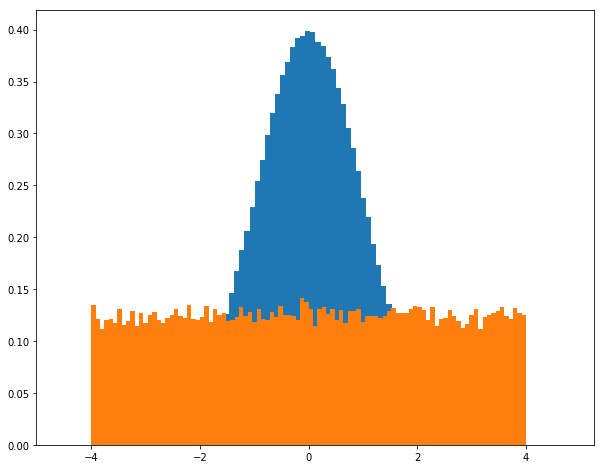

In [28]:
_ = plt.hist(data, 100, normed=1)
_ = plt.hist(inputVector[np.abs(inputVector)<4], 100, normed=1)

In [29]:
g_inpsize = 1   #we will just take 1 real number uniform distrubtion
g_hidsize = 50 #
g_outsize = 1   #we will output a real number from our data distribution

Generator = GenNet(g_inpsize, g_hidsize, g_outsize) #it is gonna perform cross entropy loss instead of softmax,
                                                         #since our labels are just real or fake, 
                                                         #it fits our purposes

d_inpsize = 1 #first check without batch normaliziton
d_hidsize = 50
d_outsize = 1 #again we are just gonna output real or fake

Discriminator = DiscNet(d_inpsize, d_hidsize, d_outsize) #we will use slightly modified version of TwoLayerNet
                                                            #we just added sigmoid at the output layer since all of
                                                        #our outputs needs to be in range [0,1]

Trainer = GANTrainer(Generator, Discriminator, data, update_rule='adam',
           num_epochs=5,
           batch_size=100,
           optim_config={
             'learning_rate': 2e-5,
           },
           lr_decay=0.995,
           verbose=True, print_every=10000)

Trainer.train()

Iteration 0/50000, Discriminator(mean,std): (0.000685,0.000000), Generated: (0.000685,0.000000)


cs231n/classifiers/neural_net.py:93: RuntimeWarning: Mean of empty slice.
  print 'Iteration %d/%d, Discriminator(mean,std): (%f,%f), Generated: (%f,%f)' % (t, num_its, passed.mean(), passed.std(), gbatch.mean(), gbatch.std())
/usr/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Iteration 10000/50000, Discriminator(mean,std): (nan,nan), Generated: (2.759887,0.098506)


cs231n/rnn_layers.py:213: RuntimeWarning: invalid value encountered in greater_equal
  pos_mask = (x >= 0)
cs231n/rnn_layers.py:214: RuntimeWarning: invalid value encountered in less
  neg_mask = (x < 0)
cs231n/layers.py:316: RuntimeWarning: divide by zero encountered in divide
  dx = -(y/x - (1.-y)/(1.-x))/N
cs231n/layers.py:87: RuntimeWarning: invalid value encountered in multiply
  dx = x*(1.-x)*dout
cs231n/layers.py:77: RuntimeWarning: invalid value encountered in greater
  dx = np.where(x > 0, dout, 0)


Iteration 20000/50000, Discriminator(mean,std): (nan,nan), Generated: (nan,nan)


KeyboardInterrupt: 

In [ ]:
plt.plot([x[0] for x in Trainer.loss_history])
plt.plot([x[1] for x in Trainer.loss_history])
plt.plot([x[2] for x in Trainer.loss_history])